# example for galactic propagation

This is an reduced example to reproduce the example in section 3.1 of the CRPropa 3.2 paper [R. Alves Batista *et al.* JCAP**09** (2022) 035](https://iopscience.iop.org/article/10.1088/1475-7516/2022/09/035)

In this example anisotropic diffuion in different magnetic field configurations is considerd. We use the default values for the parallel diffusion coeficient $\kappa_\parallel = \kappa_0 \left(\frac{E}{4 \, \mathrm{GeV}}\right)^\alpha$ with $\kappa_0 = 6.1\cdot 10^{28} \mathrm{m^2/s}$ and $\alpha = \frac{1}{3}$ as well for the anisotropy parameter $\epsilon = \kappa_\perp / \kappa_\parallel = 0.1$. We test the JF12Solenoidal field from [Kleiman *et al.* ApJ **877** (2019) 76](https://doi.org/10.3847/1538-4357/ab1913) one time alone and once with the superposition of the inter cloud component of the CMZField from [Guenduez *et al.* A&A **644** (2020) A71](https://doi.org/10.1051/0004-6361/201936081).

We simulate Protons with a fixed energy of $E_p = 10$ TeV where the source position follows the SourcePulsarDistribution. 

To calculate the stationary solution we follow the weighting approach presented in [Merten *et al.* JCAP **06** (2017) 046](https://doi.org/10.1088/1475-7516/2017/06/046). Therefore, we use the ObserverTimeEvolution with $n = 100$ steps and $\Delta t = 5 \, \mathrm{kpc} / c$.

The simulation volume is limited by a cylinder with the height of $z = \pm 2 \, \mathrm{kpc}$ over the Galactic plane and a Galactocentric radius of $r_\mathrm{gc} = 20 \, \mathrm{kpc}$.


## import of packages

In [2]:
from crpropa import * 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## simulation
This simulation is with a reduced particle number. Here only $5 \cdot 10^5$ (pseudo) particles are simulated. The plot for the CRPropa3.2 paper are produced with $10^8$ particles and a finer grid for the plots. The number of simulated (pseudo) particles can be changed in the second last line of the next cell. With the reduced particle number this example should take about four minutes for each simulation on a 12 core computer.

In [46]:
def simulation(field, name):
    """ 
        runs the simulation with different field configuration 

        field:  magnetic field
        name:   simulation name for output naming
    """
    sim = ModuleList()
    sim.setShowProgress(True)

    # propagation
    sim.add(DiffusionSDE(field))
    
    # observer and output
    out = TextOutput(name + ".txt")
    out.setLengthScale(kpc)
    out.disableAll()
    out.enable(Output.CurrentPositionColumn)
    
    nStep = 100
    deltaStep = 5 * kpc
    obs = Observer()
    time_evolution = ObserverTimeEvolution(deltaStep, deltaStep, nStep)
    obs.add(time_evolution)
    obs.setDeactivateOnDetection(False) # propagate candidates after detection
    obs.onDetection(out)
    sim.add(obs)
    
    # boundary
    sim.add(MaximumTrajectoryLength(nStep * deltaStep)) # limit propagation time, no detection afterwards possible
    rMax, zMax = 20 * kpc, 2 * kpc
    outer_bound = CylindricalBoundary(Vector3d(0), 2 * zMax, rMax)
    sim.add(outer_bound)

    # source
    source = Source()
    source.add(SourceParticleType(nucleusId(1,1))) # proton
    source.add(SourceEnergy(10 * TeV))
    source.add(SourceIsotropicEmission())
    source.add(SourcePulsarDistribution()) # for source position

    # run simulation
    Npart = int(5e5)
    sim.run(source, Npart)    

In [47]:
# only JF12Solenoidal
jf12 = JF12FieldSolenoidal()
simulation(jf12, "jf12")

# combined with CMZfield 
cmz = CMZField()
cmz.setUseMCField(False)
cmz.setUseICField(True) # only use largescale field
cmz.setUseNTFField(False)
cmz.setUseRadioArc(False)
field = MagneticFieldList()
field.addField(jf12)
field.addField(cmz)
simulation(field, "combined")

crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Nov  3 11:33:49 2022 : [ Finished ] 100%    Needed: 00:03:43  - Finished at Thu Nov  3 11:37:32 2022
crpropa::ModuleList: Number of Threads: 12
Run ModuleList
  Started Thu Nov  3 11:37:32 2022 : [ Finished ] 100%    Needed: 00:03:45  - Finished at Thu Nov  3 11:41:17 2022


## analysis

In [48]:
# load data 
names = ["X", "Y", "Z"]
data_jf12 = pd.read_csv("jf12.txt", names = names, delimiter = "\t", comment = "#")
data_cmz = pd.read_csv("combined.txt", names = names, delimiter ="\t", comment= "#")

### Face on view of the Milky-Way. 
In the paper more bins are used. The reduction of bins here is due to the lower number of propagated candidates. 


0


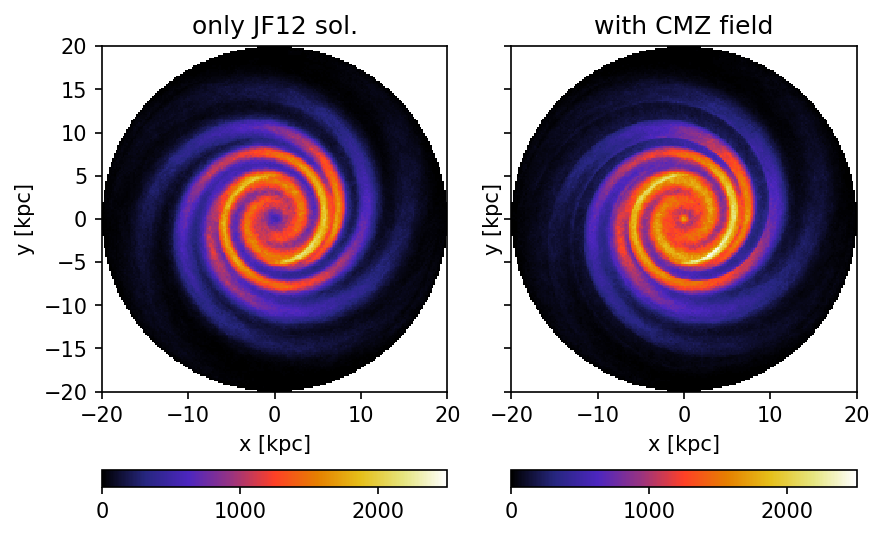

In [71]:
bins = np.linspace(-20, 20, 201) # In the paper 300 bins are used # np.linspace(-20, 20, 301)
binMid = (bins[1:] + bins[:-1])/2

nJF12 = np.histogram2d(data_jf12[abs(data_jf12.Z) < 0.3].X, data_jf12[abs(data_jf12.Z) < 0.3].Y, bins = [bins, bins])[0].T
nCMZ = np.histogram2d(data_cmz[abs(data_cmz.Z) < 0.3].X, data_cmz[abs(data_cmz.Z) < 0.3].Y, bins = [bins, bins])[0].T

# restrict to simulaiton volume
vmax = np.max([nJF12.max(), nCMZ.max()])
mXY, mYX = np.meshgrid(binMid, binMid)
boolR = ((mXY**2 + mYX**2) > 20**2)
nJF12[boolR] = np.nan
nCMZ[boolR] = np.nan

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, dpi = 150)

p1 = ax1.pcolormesh(binMid, binMid, nJF12, cmap = plt.cm.CMRmap, vmax=vmax)
ax1.set_title("only JF12 sol.")

p2 = ax2.pcolormesh(binMid, binMid, nCMZ, cmap = plt.cm.CMRmap, vmax=vmax)
ax2.set_title("with CMZ field")

for ax in (ax1, ax2):
    ax.set_aspect("equal")
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")

plt.colorbar(p1, orientation = "horizontal", ax = ax1)
plt.colorbar(p2, orientation = "horizontal", ax = ax2)

fig.tight_layout()
plt.show()

### edge on view of the Milky-Way
Additional plot of a edge on view of the Milkyway. Here, all data are integrated over the y-axis. 

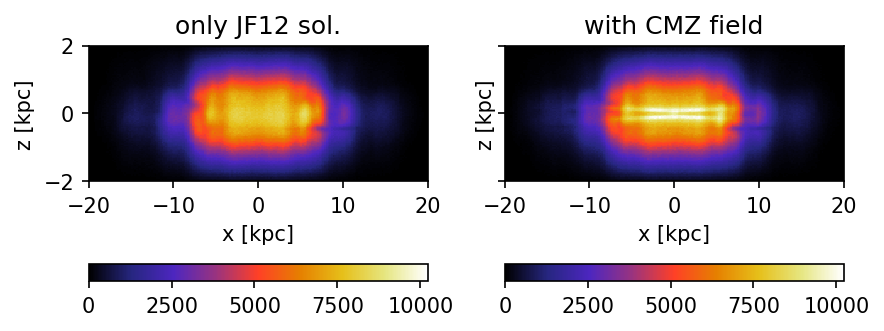

In [87]:
binsZ = np.linspace(-2, 2, 101)
binMidZ = (binsZ[1:] + binsZ[:-1])/2

nJF12 = np.histogram2d(data_jf12.X, data_jf12.Z, bins = [bins, binsZ])[0].T
nCMZ = np.histogram2d(data_cmz.X, data_cmz.Z, bins = [bins, binsZ])[0].T

vmax = np.max([nJF12.max(), nCMZ.max()])

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, dpi = 150)

p1 = ax1.pcolormesh(bins, binsZ, nJF12, cmap = plt.cm.CMRmap, vmax=vmax)
ax1.set_title("only JF12 sol.")

p2 = ax2.pcolormesh(bins, binsZ, nCMZ, cmap = plt.cm.CMRmap, vmax=vmax)
ax2.set_title("with CMZ field")

for ax in (ax1, ax2):
    ax.set_aspect(4)
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("z [kpc]")

plt.colorbar(p1, orientation = "horizontal", ax = ax1)
plt.colorbar(p2, orientation = "horizontal", ax = ax2)

fig.tight_layout()
plt.show()

### distribution over the z-axis
Additional plot showing the distribution over the z-axis. 

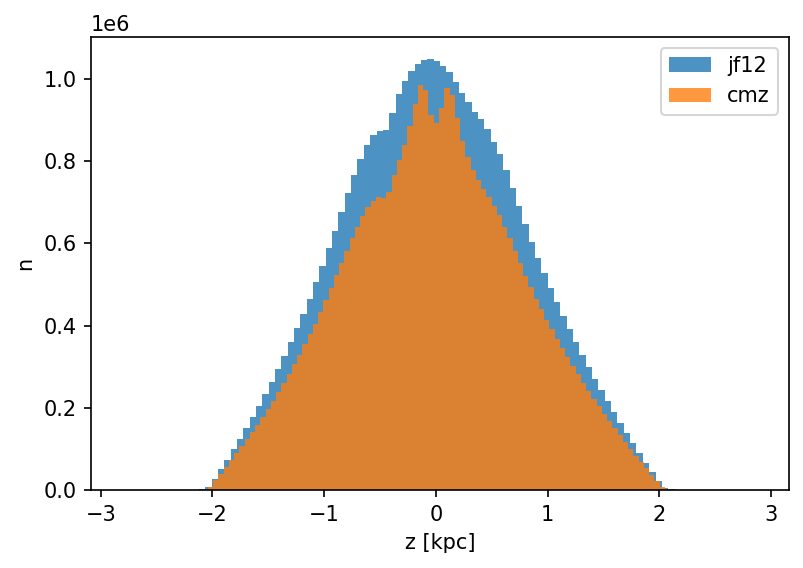

In [90]:
plt.figure(dpi = 150)
plt.hist(data_jf12.Z, bins = 100, alpha = .8, label="jf12")
plt.hist(data_cmz.Z, bins = 100, label="cmz", alpha = .8)
plt.xlabel("z [kpc]")
plt.ylabel("n")
plt.legend()
plt.show()
